### https://github.com/catboost/tutorials/blob/master/feature_selection/select_features_tutorial.ipynb

### https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

In [1]:
from catboost import Pool
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [15]:
path = "/Users/thrilok/Desktop/mantra_collab_job/work_files/latest_broko_code"
df = pd.read_csv(path + "/Dataset/ML_CLEAN_DATA__Bdv2.1_RES.csv")
df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182234 entries, 0 to 182233
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ML_Number         182234 non-null  object 
 1   Address           182230 non-null  object 
 2   Area              182227 non-null  object 
 3   Postal_Code       182005 non-null  object 
 4   Postal_Short      182005 non-null  object 
 5   Style             182234 non-null  object 
 6   Type              182234 non-null  object 
 7   Cluster           182234 non-null  object 
 8   Cluster_Price     182234 non-null  float64
 9   Taxes             182196 non-null  float64
 10  Cluster_Tax       182234 non-null  float64
 11  Air_Conditioning  168023 non-null  object 
 12  Bedrooms          182234 non-null  int64  
 13  Basement1         182234 non-null  object 
 14  Days_On_Market    182233 non-null  float64
 15  Exterior1         181090 non-null  object 
 16  Garage_Type       15

/var/folders/4d/gx0lrt1n0l34spb_k9cnkfpr0000gn/T/ipykernel_75004/3026882676.py:2: DtypeWarning:

Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.



In [16]:
drop_cols = ['ML_Number','Sold_Date',"Address","Area","Postal_Code","Air_Conditioning","Exterior1","Rooms","Tax_Year","Water_Included","property_type"]#,"lat","lng"]
data = df.drop(drop_cols, axis=1)
data.isnull().sum()

Postal_Short        229
Style                 0
Type                  0
Cluster               0
Cluster_Price         0
Taxes                38
Cluster_Tax           0
Bedrooms              0
Basement1             0
Days_On_Market        1
Garage_Type       27627
Sold_Price            2
Washrooms             0
lat                  18
lng                  18
dtype: int64

In [17]:
data = data.dropna(axis = 0, how ='any')

In [18]:
# df.dropna(subset=['_Listing_Price', 'Air_Conditioning', 'Approx_Square_Footage', 'Exterior1', 'Garage_Type', 'Locker' ,'Pets_Permitted', 'Rooms', 'Water_Included', 'Approx_Square_Footage_Min', 'Approx_Square_Footage_Max', 'lat','lng','Postal_Code'], inplace=True)

In [19]:
# from sklearn.preprocessing import LabelEncoder

# # Create an instance of LabelEncoder for each categorical column
# label_encoders = {}
# categorical_columns = ['Air_Conditioning','Approx_Square_Footage','Basement1','Exterior1','Garage_Type','Street_Name','Style','Type','Postal_Code','Heat_Included','Heat_Type','Locker','Parking_Included','Pets_Permitted','Street_Name','Style','Type','Water_Included','Postal_Code']

# label_encoders = {}
# for feature in categorical_columns:
#     le = LabelEncoder()
#     df[feature] = le.fit_transform(df[feature])
#     label_encoders[feature] = le

In [20]:
X = data.drop('Sold_Price',axis=1)
y = data['Sold_Price']

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

feature_names = list(train_X.columns)

#categorical features
cat_features = [column for column, dtype in train_X.dtypes.items() if dtype==object]

train_X[cat_features] = train_X[cat_features].fillna('NA')
test_X[cat_features] = test_X[cat_features].fillna('NA')

train_pool = Pool(train_X, train_y, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(test_X, test_y, feature_names=feature_names, cat_features=cat_features)


In [22]:
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

def select_features_sale(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=1500, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=10,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [23]:
shap_summary = select_features_sale(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['Postal_Short', 'Type', 'Cluster_Price', 'Taxes', 'Cluster_Tax', 'Bedrooms', 'Basement1', 'Days_On_Market', 'Washrooms', 'lat']


In [36]:
# steps 9: # Selected features: ['_Listing_Price', 'Bedrooms', 'Exterior1', 'Heat_Included', 'Parking_Included', 'Rooms', 'Style', 'Type', 'Taxes', 'Washrooms', 'Water_Included', 'lng', 'List_Price', 'Year', 'Day']




# steps 3: Selected features: ['_Listing_Price', 'Basement1', 'Garage_Type', 'Heat_Included', 'Parking_Included', 'Pets_Permitted', 'Rooms', 'Street_Name', 'Style', 'Water_Included', 'lat', 'lng', 'Postal_Code', 'List_Price', 'Year']

SHAP with catboost

In [24]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [25]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123,cat_features =cat_features)
model.fit(X, y, verbose=False, plot=False)

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [27]:
# visualize the training set predictions
# shap.force_plot(explainer.expected_value, shap_values, X)

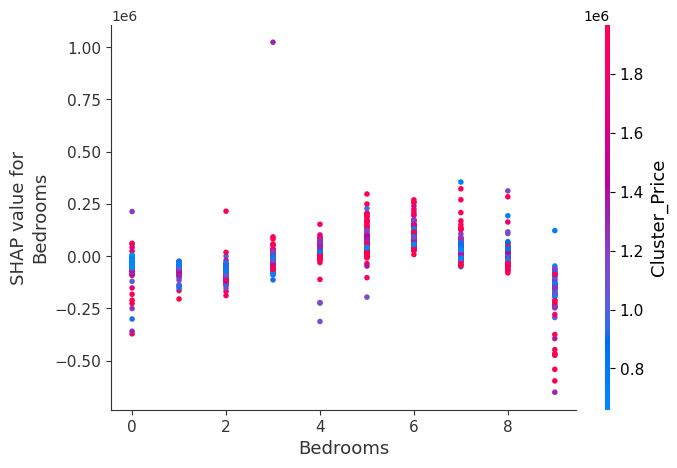

In [29]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Bedrooms", shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


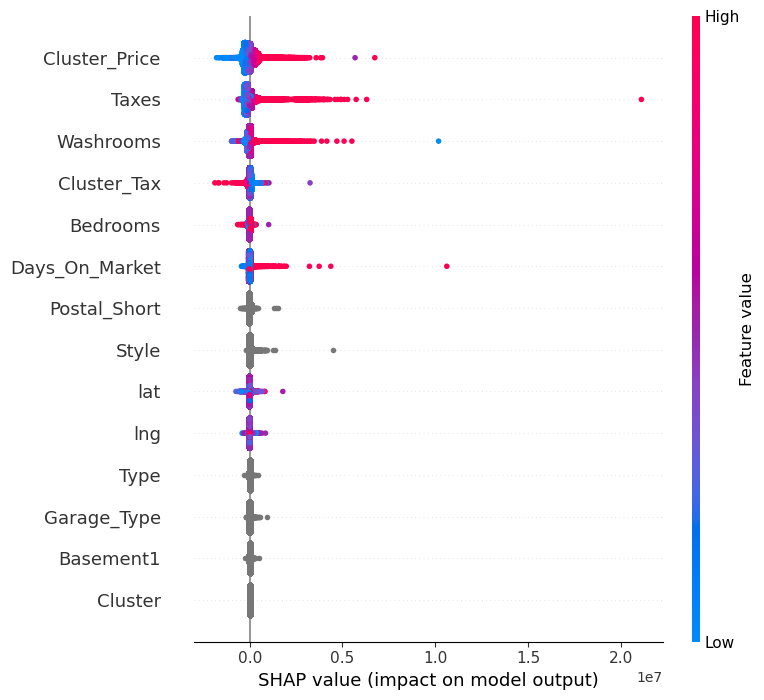

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-catboost

Text(0.5, 1.0, 'Feature Importance')

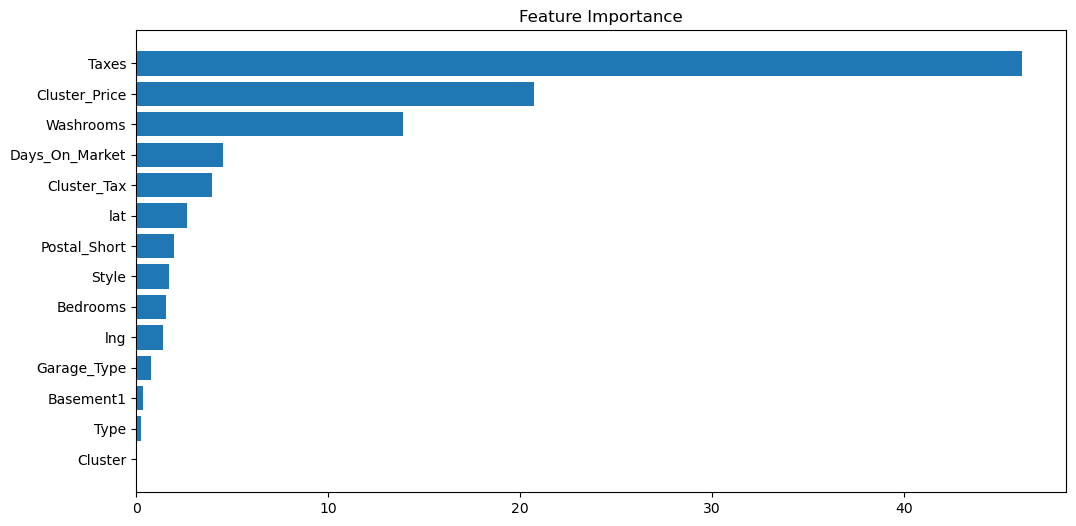

In [31]:
# Plot the tree-based (or Gini) importance
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

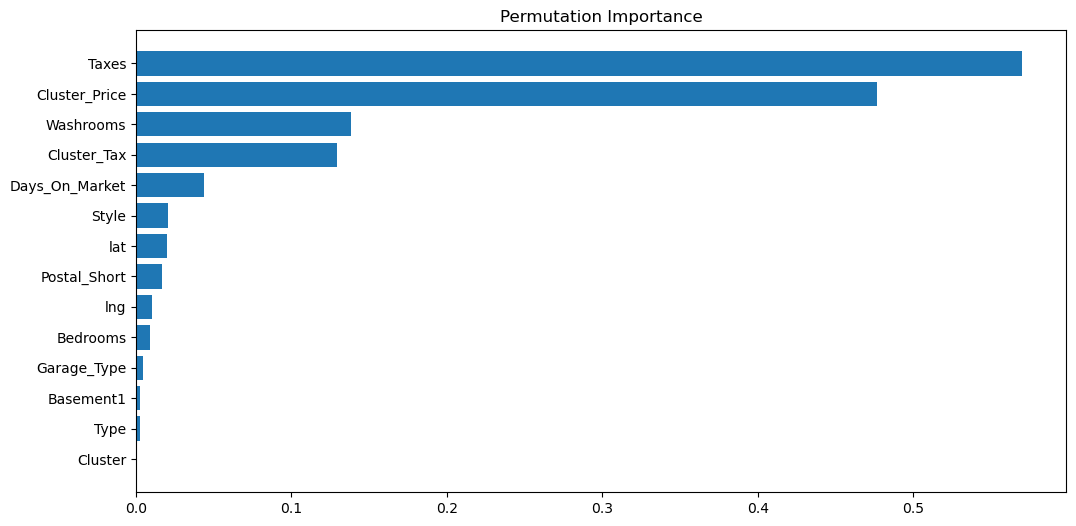

In [32]:
from sklearn.inspection import permutation_importance

# Plot the permutation importance
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance')

Text(0.5, 1.0, 'SHAP Importance')

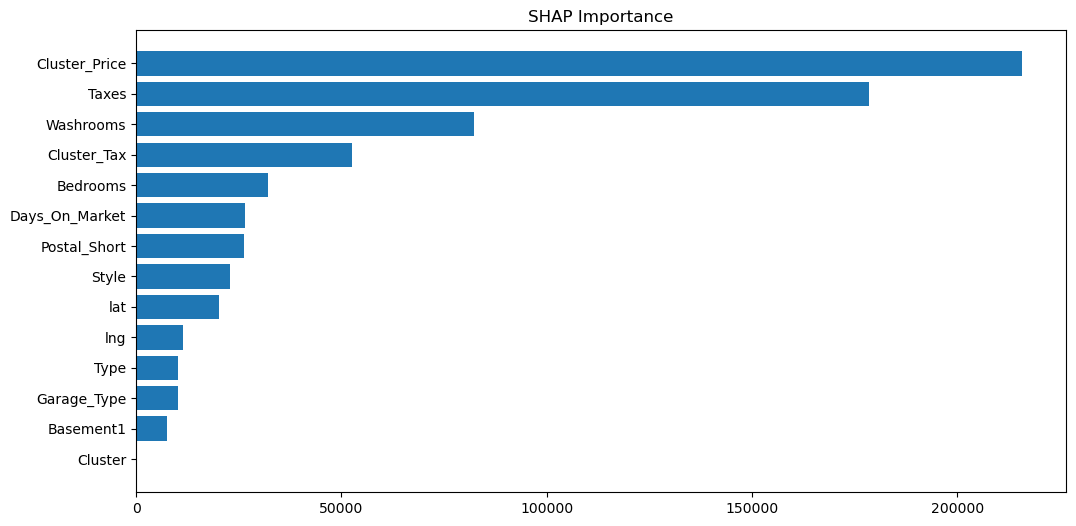

In [33]:
# Plot the mean absolute value of the SHAP values

explainer = shap.Explainer(model)
shap_values = explainer(X)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('SHAP Importance')


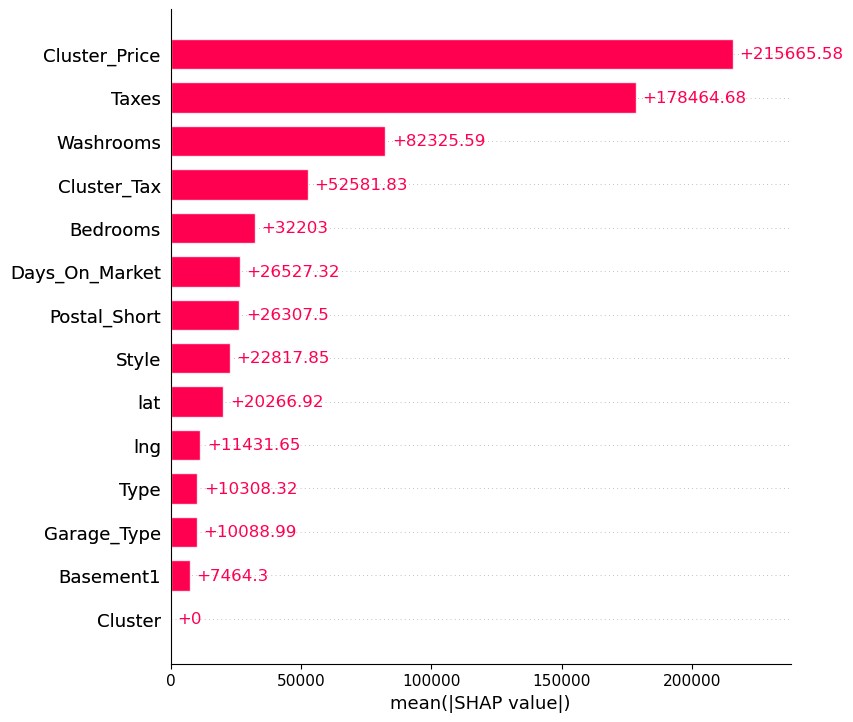

In [34]:
shap.plots.bar(shap_values, max_display=X.shape[0])